patchify: (batch_size, nr_channels, width, height)=(18623, 1, 28, 28)
patchify: (batch_size, nr_channels, width, height)=(3147, 1, 28, 28)


C:\temp\ipykernel_32836\4211786722.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


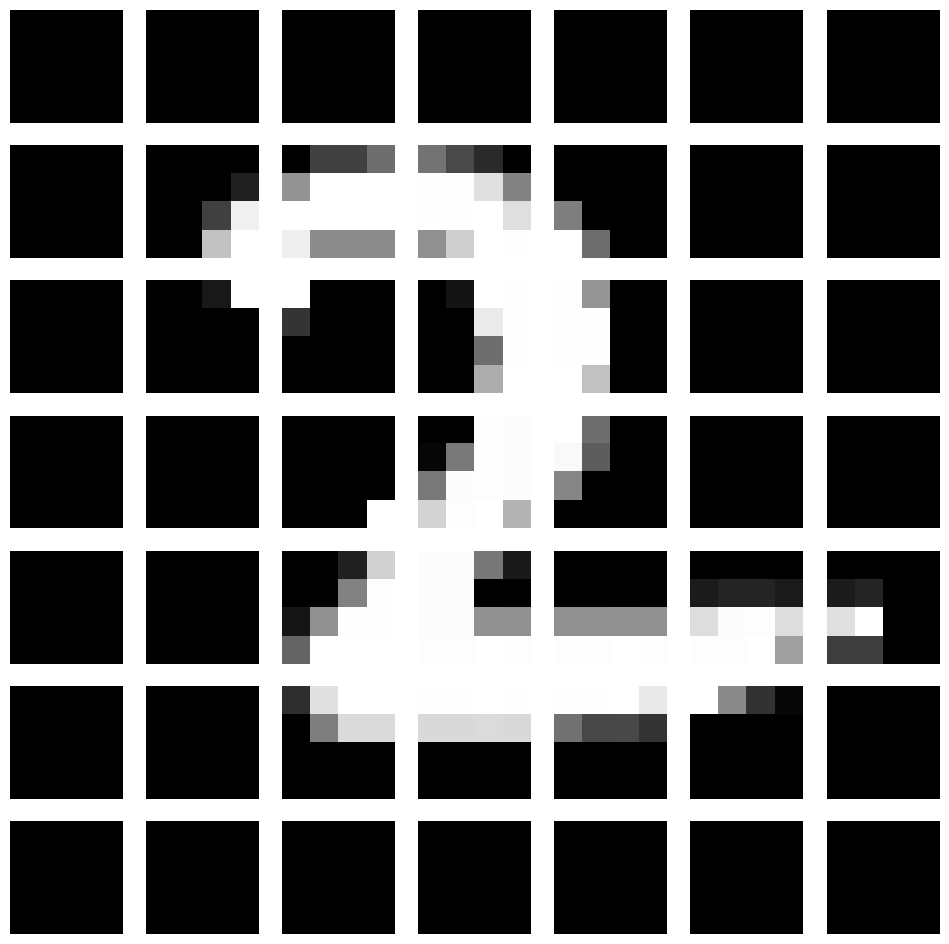

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

class FilteredMNISTDataset(Dataset):
    def __init__(self, digits, nr_patches_per_axis, rescaled_height, rescaled_width, train=True):
        self.digits = digits
        self.nr_patches_per_axis = nr_patches_per_axis
        self.mnist_dataset = datasets.MNIST(root='./data', train=train, download=True)
        self.nr_channels = 1
        self.pre_patch_height = rescaled_height
        self.pre_patch_width = rescaled_width
        
        if digits == -1:
            digits = list(range(10))
            self.digits = digits
            # self.filtered_indices = list(range(len(self.mnist_dataset)))

        self.filtered_indices = [i for i, label in enumerate(self.mnist_dataset.targets) if label in digits]
        
        self.data = self.mnist_dataset.data[self.filtered_indices]

        self.data = self.data.view(self.data.shape[0], -1 , self.pre_patch_height, self.pre_patch_width) # add the "channel" which is just 1

        self.data = F.interpolate(self.data, size=(rescaled_height, rescaled_width), mode='bilinear', align_corners=False)

        self.targets = self.mnist_dataset.targets[self.filtered_indices]

        self.data = self.patchify(self.data, nr_patches_per_axis)
    
    def visualize_patches(self, idx):

        fig, axes = plt.subplots(self.nr_patches_per_axis, self.nr_patches_per_axis, figsize=(12, 12))

        patch_height = self.pre_patch_height//self.nr_patches_per_axis
        patch_width = self.pre_patch_width//self.nr_patches_per_axis

        patches_for_cur_img, _ = self.__getitem__(idx)
        for i in range(self.nr_patches_per_axis):
            for j in range(self.nr_patches_per_axis):
                cur_patch = patches_for_cur_img[i*self.nr_patches_per_axis+j]
                cur_patch_unflattened = cur_patch.view(patch_height, patch_width)

                ax = axes[i, j]
                ax.imshow(cur_patch_unflattened, cmap='gray')
                ax.axis('off')
        
        fig.show()

    def __len__(self):
        return len(self.filtered_indices)

    def patchify(self, images, nr_patches_per_axis):

        batch_size, nr_channels, height, width = images.shape
        print(f'patchify: {(batch_size, nr_channels, width, height)=}')
        assert height % nr_patches_per_axis == 0
        assert width % nr_patches_per_axis == 0

        patch_height = height//nr_patches_per_axis
        patch_width = width//nr_patches_per_axis
        nr_floats_in_patch = nr_channels*patch_width*patch_height
        patches = torch.empty(batch_size, nr_patches_per_axis*nr_patches_per_axis, nr_floats_in_patch)

        self.patch_height = patch_width
        self.patch_width = patch_width

        for nr_cur_batch in range(batch_size):
            for i in range(nr_patches_per_axis):
                for j in range(nr_patches_per_axis):
                    cur_patch = images[nr_cur_batch, :, (patch_height*i):(patch_height*(i+1)), (patch_width*j):(patch_width*(j+1))]
                    patches[nr_cur_batch, i*nr_patches_per_axis+j, :] = cur_patch.flatten()
        
        return patches

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.targets[idx]
        
        return image, label

def visualize_dataset(dataloader, num_images=16):
    """
    Visualizes a batch of images from the DataLoader.

    :param dataloader: DataLoader for the dataset.
    :param num_images: Number of images to display.
    """
    # Get a batch of images and labels
    images, labels = next(iter(dataloader))

    # Plot the images in a grid
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')
    plt.show()

NR_PATCHES_PER_AXIS = 7
RESCALED_HEIGHT = 28
RESCALED_WIDTH = 28

filtered_digits = [0, 1, 2]
filtered_mnist_dataset_train = FilteredMNISTDataset(digits=filtered_digits, rescaled_height=RESCALED_HEIGHT, rescaled_width=RESCALED_WIDTH, nr_patches_per_axis=NR_PATCHES_PER_AXIS, train=True)
filtered_mnist_dataset_test = FilteredMNISTDataset(digits=filtered_digits, rescaled_height=RESCALED_HEIGHT, rescaled_width=RESCALED_WIDTH, nr_patches_per_axis=NR_PATCHES_PER_AXIS, train=False)

filtered_mnist_dataset_train.visualize_patches(88)

C:\temp\ipykernel_32836\4211786722.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


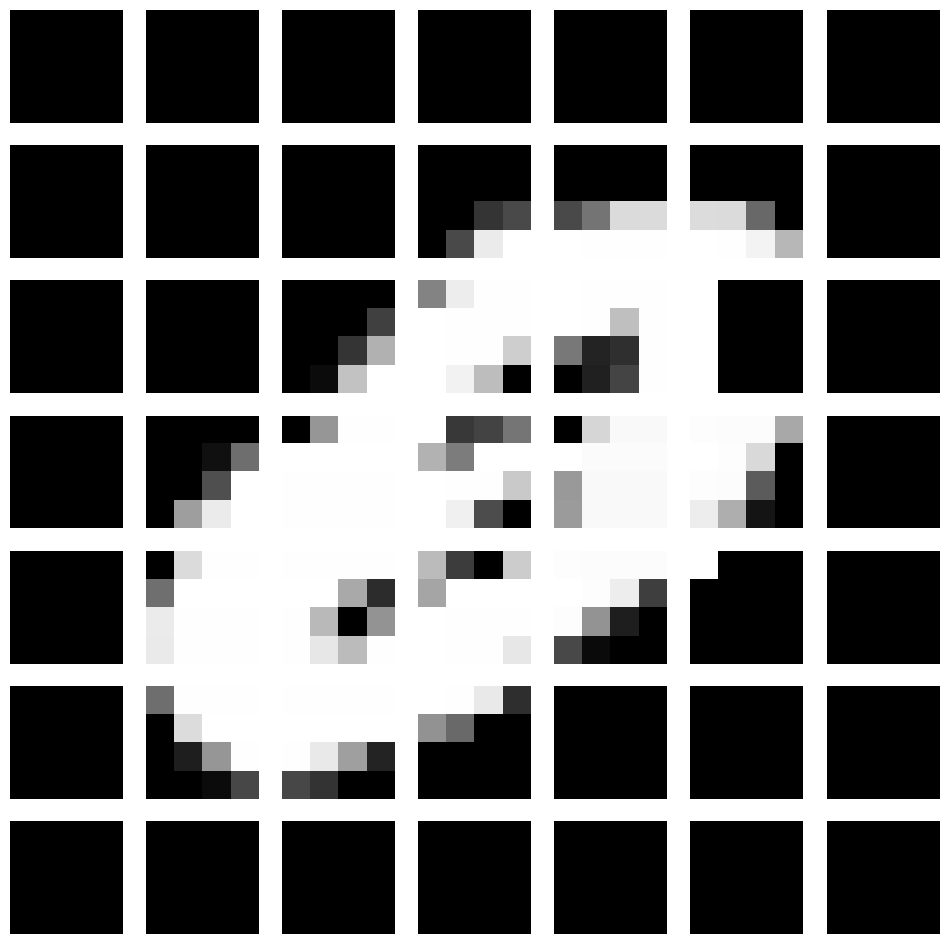

In [2]:
import numpy as np
filtered_mnist_dataset_train.visualize_patches(int(np.random.uniform(low=0, high=len(filtered_mnist_dataset_train))))

x.shape=torch.Size([33, 1000, 64])
(x.shape, output.shape)=(torch.Size([33, 1000, 64]), torch.Size([33, 1000, 64]))


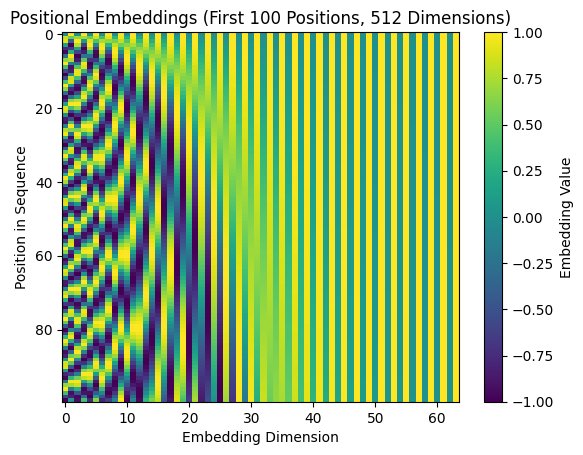

In [3]:
import importlib

import matplotlib.pyplot as plt

import transformer
importlib.reload(transformer)
from transformer import *

model_dim = 64
batch_size = 33
nr_embeddings = 1000
attention = MultiHeadAttention(nr_heads=4, model_dim=model_dim, use_masked_attention=False)
x = torch.randn(batch_size, nr_embeddings, model_dim)
print(f'{x.shape=}')
output = attention(x)
print(f'{(x.shape, output.shape)=}')
assert x.shape == output.shape

plt.figure()

# Instantiate the positional embeddings
pos_embed_layer = PositionalEmbeddings(model_dim=model_dim, max_len=500)

# Extract the positional embeddings
pe = pos_embed_layer.pe[0].cpu().numpy()

# Plot the positional embeddings for the first 100 positions and all dimensions
plt.imshow(pe[:100, :], aspect='auto', cmap='viridis')
plt.colorbar(label='Embedding Value')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position in Sequence')
plt.title('Positional Embeddings (First 100 Positions, 512 Dimensions)')
plt.show()

In [4]:
import transformer
importlib.reload(transformer)
from transformer import *

class ViT(torch.nn.Module):
    def __init__(self, nr_encoders, nr_heads, model_dim, input_image_shape, nr_patches_per_axis, nr_output_classes, nr_channels, patch_height, patch_width):
        super().__init__()
        self.nr_heads = nr_heads
        self.model_dim = model_dim
        self.nr_encoders = nr_encoders
        self.nr_patches_per_axis = nr_patches_per_axis

        assert nr_patches_per_axis == filtered_mnist_dataset_train.nr_patches_per_axis

        self.class_input = nn.Parameter(torch.randn(nr_channels*patch_width*patch_height)).view(1, -1)

        self.mlp_classifier = OutputClassEmbeddingToClass(transformer_model_dim=model_dim, nr_output_classes=nr_output_classes)

        self.transformer = Transformer(nr_encoder_decoder_blocks=nr_encoders, nr_heads=nr_heads, model_dim=model_dim, max_input_tokens=nr_patches_per_axis**2+1, nr_input_features=patch_height*patch_width*nr_channels, use_masked_attention=False)
    
    def forward(self, x_patchified):
        # 1. repeats class token to batch_size dimensions
        # 2. turns the patches into embeddings
        # 3. concatonates class embeddings to patch embeddings
        # 4. adds positional embeddings
        # 5. finally passes trough the encoders
        # 6. classifies from the last embedding (corresponding class embedding) with an mlp

        nr_batches = x_patchified.shape[0]

        class_input_repeated = self.class_input.tile(dims=(nr_batches, 1)).view(nr_batches, 1, -1)

        trans_input = torch.cat((x_patchified, class_input_repeated), dim=1)

        output = self.transformer(trans_input)
        
        # we take last embedding instead of the first like in the paper, because torch.cat adds to the end
        return self.mlp_classifier(output[:, -1, :])
    

class OutputClassEmbeddingToClass(torch.nn.Module):
    def __init__(self, transformer_model_dim, nr_output_classes):
        super().__init__()
        self.mlp = nn.Sequential(
                    nn.Linear(in_features=transformer_model_dim, out_features=nr_output_classes),
                    nn.Softmax(dim=-1)
                )

    def forward(self, output_class_embedding):
        return self.mlp(output_class_embedding)


# Create a DataLoader for the dataset
dataloader = DataLoader(filtered_mnist_dataset_train, batch_size=4, shuffle=True)

# nr_input_embeddings = 100
# input_dimensions=666
# x = torch.randn(batch_size, nr_input_embeddings, *input_image_shape)
# batch_size = 2
# x = torch.randn(batch_size, *input_image_shape)

input_image_shape=(1, 28, 28)
x_patchified, label = next(iter(dataloader))
vit = ViT(nr_encoders=2, nr_heads=2, model_dim=8, input_image_shape=input_image_shape, nr_patches_per_axis=filtered_mnist_dataset_train.nr_patches_per_axis, nr_output_classes=len(filtered_mnist_dataset_train.digits), nr_channels=filtered_mnist_dataset_train.nr_channels,
          patch_height=filtered_mnist_dataset_train.patch_height, patch_width=filtered_mnist_dataset_train.patch_width)

print(f'{(x_patchified.shape, output.shape)=}')

for images, labels in dataloader:
    output = vit(images)
    print(f'{(images.shape, output.shape)=}')
    print(f'{output=}')
    break

(x_patchified.shape, output.shape)=(torch.Size([4, 49, 16]), torch.Size([33, 1000, 64]))
(images.shape, output.shape)=(torch.Size([4, 49, 16]), torch.Size([4, 3]))
output=tensor([[0.0984, 0.1297, 0.7719],
        [0.1081, 0.3067, 0.5852],
        [0.0828, 0.3152, 0.6019],
        [0.0619, 0.2781, 0.6600]], grad_fn=<SoftmaxBackward0>)


Epoch [1/10], Loss: 0.9051


Epoch [2/10], Loss: 0.8310


Epoch [3/10], Loss: 0.8036


Epoch [4/10], Loss: 0.7870


Epoch [5/10], Loss: 0.7804


Epoch [6/10], Loss: 0.7702


Epoch [7/10], Loss: 0.7626


Epoch [8/10], Loss: 0.7580


Epoch [9/10], Loss: 0.7535


Epoch [10/10], Loss: 0.7495
Finished Training


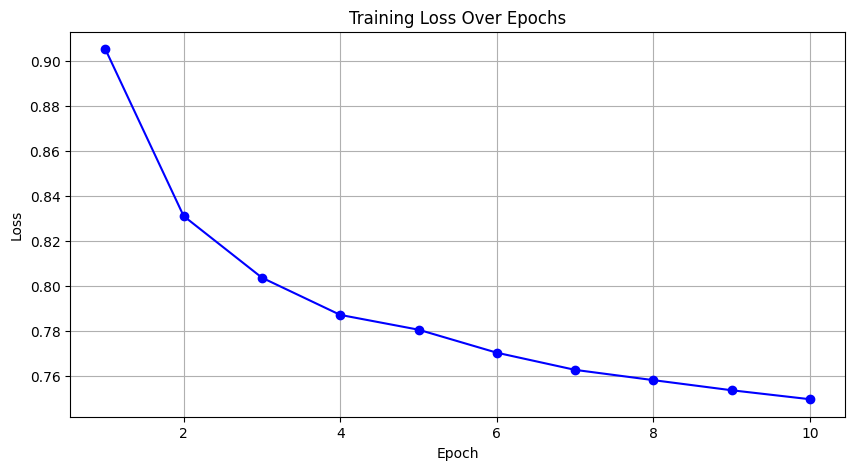

In [8]:
from tqdm import tqdm

# Initialize the model, loss function, and optimizer
input_image_shape = (1, 28, 28)
vit = ViT(nr_encoders=2, nr_heads=2, model_dim=8, input_image_shape=input_image_shape, nr_patches_per_axis=filtered_mnist_dataset_train.nr_patches_per_axis,
          nr_output_classes=len(filtered_mnist_dataset_train.digits), patch_height=filtered_mnist_dataset_train.patch_height, patch_width=filtered_mnist_dataset_train.patch_width, nr_channels=filtered_mnist_dataset_train.nr_channels)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.parameters(), lr=0.005)

dataloader = DataLoader(filtered_mnist_dataset_train, batch_size=128, shuffle=True)

loss_values = []
num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit.to(device)

for epoch in range(num_epochs):
    vit.train()
    running_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vit(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / (progress_bar.n + 1))
    
    epoch_loss = running_loss / len(dataloader)
    loss_values.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

print('Finished Training')

# Plot the loss function graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [9]:
def calculate_accuracy_and_loss(model, test_dataloader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    average_loss = running_loss / len(test_dataloader)
    print(f'Accuracy: {accuracy:.2f}%, Loss: {average_loss:.4f}')
    return accuracy, average_loss

# Example usage
test_dataloader = DataLoader(filtered_mnist_dataset_test, batch_size=128, shuffle=True)
criterion = torch.nn.CrossEntropyLoss()

calculate_accuracy_and_loss(vit, test_dataloader, criterion)

Accuracy: 79.98%, Loss: 0.7434


(79.9809342230696, 0.7434191226959228)

In [11]:
# import matplotlib.pyplot as plt
# import torch
# from torch.utils.data import DataLoader

# # Function to visualize inputs and corresponding model outputs
# def visualize_model_outputs(model, dataloader, device, num_images=5):
#     model.eval()
#     images_so_far = 0
#     fig = plt.figure(figsize=(15, 15))

#     with torch.no_grad():
#         for i, (images, labels) in enumerate(dataloader):
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, preds = torch.max(outputs, 1)

#             for j in range(images.size(0)):
#                 if images_so_far == num_images:
#                     model.train()
#                     return
#                 images_so_far += 1
#                 ax = plt.subplot(num_images // 2, 2, images_so_far)
#                 ax.axis('off')
#                 ax.set_title(f'Predicted: {preds[j].item()}')
#                 img = images[j].cpu().numpy().squeeze()
#                 plt.imshow(img, cmap='gray')

#     model.train()

# # Example usage
# dataloader = DataLoader(filtered_mnist_dataset_test, batch_size=64, shuffle=True)

# # Visualize some inputs and corresponding model outputs
# visualize_model_outputs(vit, dataloader, device, num_images=10)